# Homework 1 (Due: Feb 2, 2018)

## 1. Ornstein-Uhlenbeck process

The current/conductance input that a neuron gets *in vivo* is often modeled as a stochastic process with Gaussian statistics. However, pure Gaussian white noise is unfeasible due to lack of the temporal correlartion seen in experimental data, and therefore the time series called Ornstein-Uhlenbeck (OU) process is widely used. It is defined by

$$
X(t+1) = X(t) - \alpha \cdot X(t) + \sigma \zeta(t),
$$

where $\alpha$ and $\sigma$ are numerical parameters, and $\zeta(t)$ is Gaussian white noise updated at each time step.

1. Write a Python function to generate an OU process from given parameters alpha and sigma. The function should also return the white noise ($\zeta$) used. Plot an example comparing the OU process and white noise side by side.

2. For fixed sigma, plot how the variance of an OU process changes with alpha. What seems to be the relationship?


### 1.1

In [47]:
import numpy as np
from numpy.random import randn

def generate_OU(a, sigma, xinit, L):
    x = np.zeros(L)
    zeta = randn(L)
    x[0] = xinit
    for i, z in enumerate(zeta[:-1]):
        x[i+1] = x[i]-a*x[i] + z
    return x, zeta, np.arange(L)


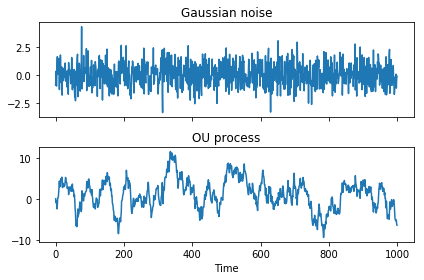

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, sharex=True)
x, z, t = generate_OU(0.025, 1, 0, 1000)
ax[0].plot(t, z)
ax[0].set(title='Gaussian noise')
ax[1].plot(t, x)
ax[1].set(title='OU process', xlabel='Time')
plt.tight_layout()

### 1.2


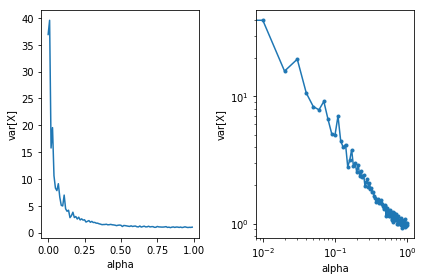

In [46]:
alphas = []   # Here we collect alpha's
xvars = []    # and here the variance of the OU process

Ngrid = 100   # We try 100 alpha's from 0 to 1
da = 1./Ngrid # Step size

for i in range(Ngrid):
    a = da*i            # Compute each alpha
    alphas.append(a)    
    x, _, _ = generate_OU(a, 1.0, 0.0, 1000) # Generate an OU process
    xvars.append(np.var(x)) # Collect the variance
    
fig, ax = plt.subplots(ncols=2)
ax[0].plot(alphas, xvars)
ax[0].set(xlabel='alpha', ylabel='var[X]')

# Here we make the same plot in the log-log axes
ax[1].loglog(alphas, xvars, '.-')
ax[1].set(xlabel='alpha', ylabel='var[X]')
plt.tight_layout()


## 2. Attenuation and propagation

1. In our axon example in the NEURON tutorial 1 with the `pas` mechanism, increase the number of recording sites so that we can densely monitor the membrane voltage of the axon. From this, plot how the membrane voltage attenuates in distance (x*L) at t=100. Try different `nseg` values and explain how the accuracy of the measurement improves with `nseg`.

2. Add the `hh` mechanism in the axon, and measure the propagation speed of an action potential along the axon by comparing spatial voltage profiles at multiple time points (If necessary, increase `L`). How does the accuracy improve with `nseg`? 

![](images/r18_1_sections.png)

### 2.1

Here we start from importing necessary modules:

In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
import CNSutil

And we create an axon and add a current clamp,

In [2]:
# Create an axon
axon = h.Section(name="axon")
axon.L = 500 # 500 um long
axon.diam = 1 # 1 um diameter 

axon.insert("pas")

# Add a current clamp
ic = h.IClamp(1e-3, sec=axon)
ic.delay = 0 # 0 ms delay
ic.dur = 1e2 # 100 ms duration
ic.amp = 0.200 # 200 pA

Here we define functions to run and plot results:

In [3]:
dt = 0.1  # 10 kHZ sampling

def run_and_record(n_recording_locations):
    """runs a simulation while recording from equally spaced points along 
    the axon. The number of the points is given by n_recording_locations"""
    reclist = []
    for i in range(n_recording_locations):
        reclist.append(h.Vector())
        reclist[i].record(axon(1e-3+float(i)/n_recording_locations)._ref_v, dt)
    
    h.tstop = 1e2 # run for 100 ms.
    h.init()
    h.run()
    
    return(reclist)


def plot_recordings(reclist):
    """plots the recorded membrane voltages"""
    t = np.arange(1001)*dt
    fig, ax = plt.subplots()
    for v in reclist:
        ax.plot(t, v)
        ax.set(xlabel="T (ms)", ylabel="Voltage (mV)")
    return fig



Let's first try `nseg=100` while recording from 100 locations

<IPython.core.display.Javascript object>


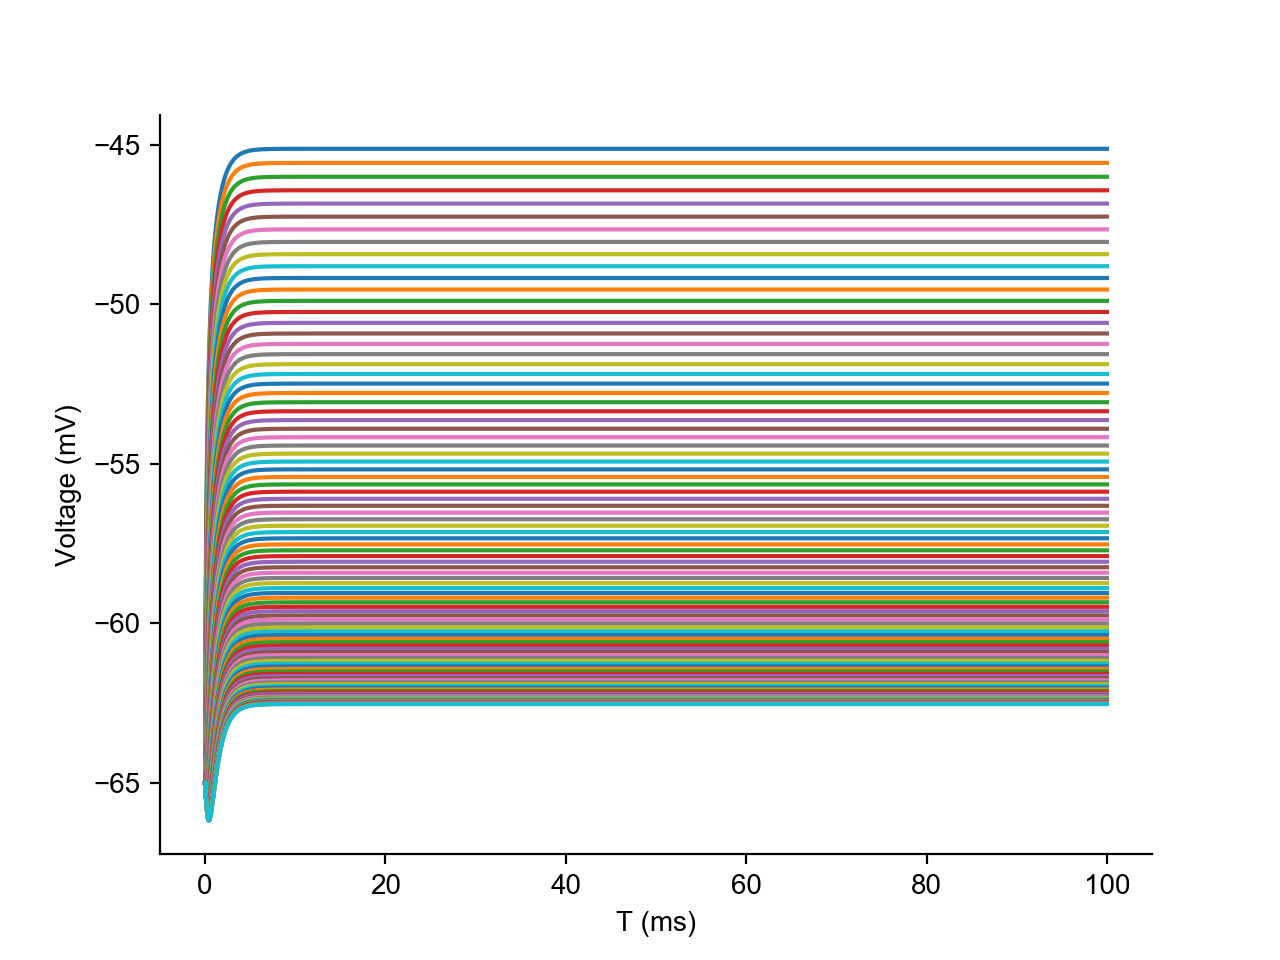

In [4]:
axon.nseg = 100 
ic.loc(1e-3) # relocate the current clamp electrode

reclist = run_and_record(100)

%matplotlib notebook
_ = plot_recordings(reclist)

We can also make a 2d plot,

<IPython.core.display.Javascript object>


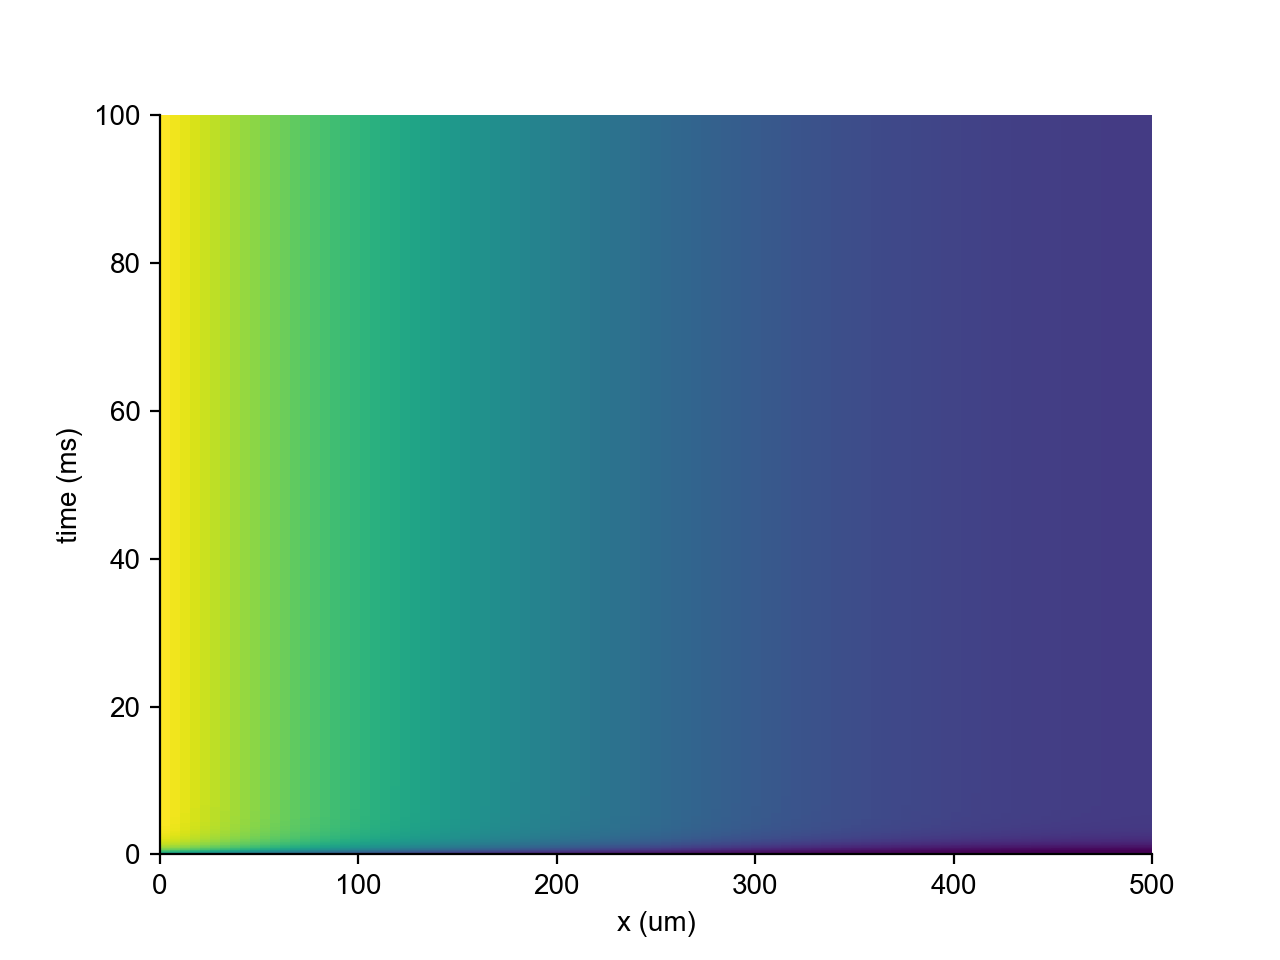

[Text(0,0.5,'time (ms)'), Text(0.5,0,'x (um)')]

In [6]:
# Transform reclist to a 2d matrix
recs = CNSutil.convert_to_array(reclist)

fig, ax = plt.subplots()
x = np.linspace(0, axon.L, len(reclist))
t = np.arange(1001)*dt
ax.pcolormesh(x, t, recs, shading='flat')
ax.set(xlabel='x (um)', ylabel='time (ms)')


Now let's plot the membrane voltage at *t*=100 ms.

<IPython.core.display.Javascript object>


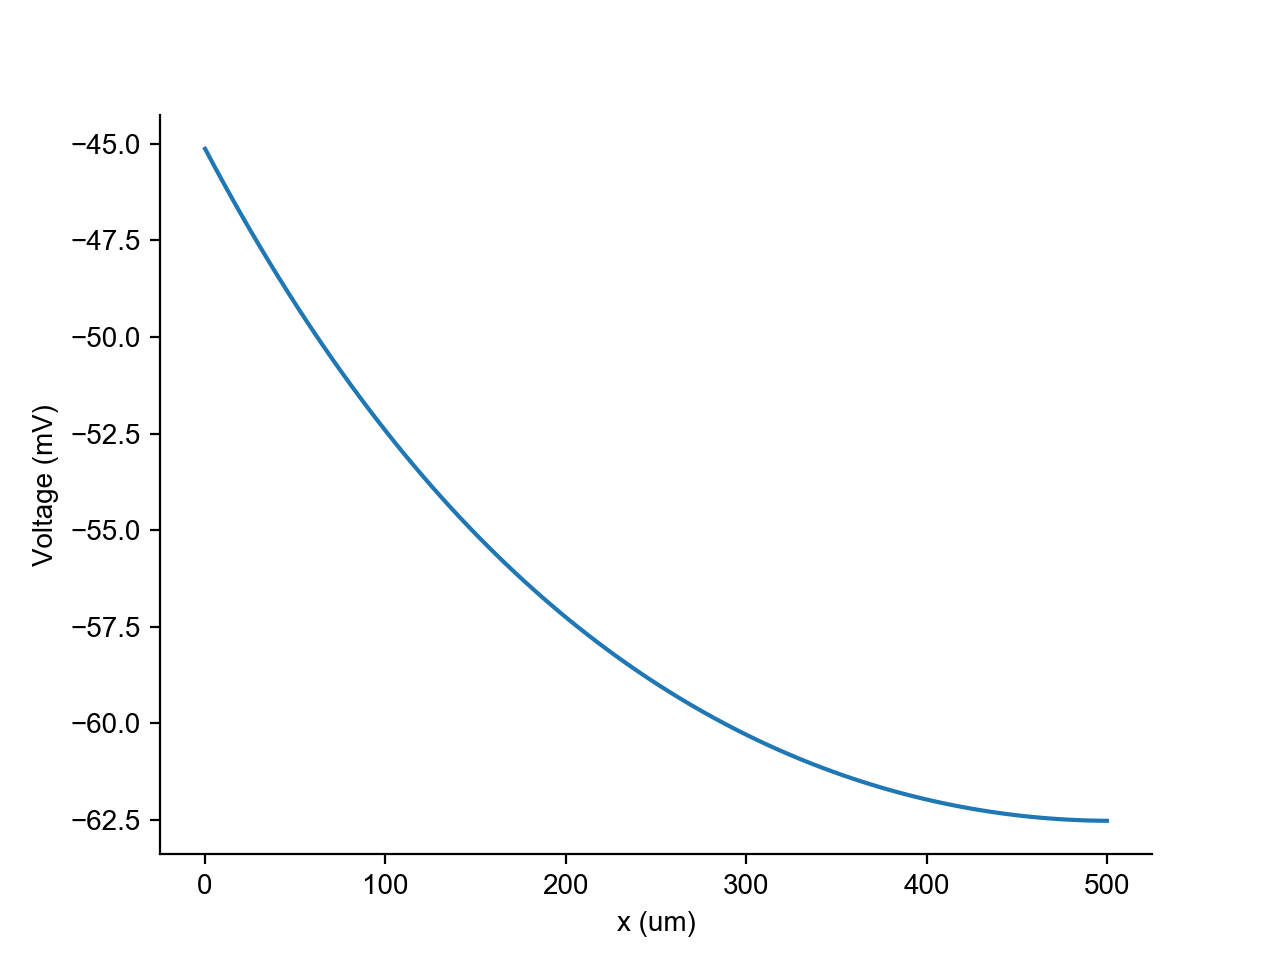

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'x (um)')]

In [7]:
fig, ax = plt.subplots()
ax.plot(x, recs[-1,:]) # recs = T x X matrix, T: time dimension, X: spatial dimension
ax.set(xlabel='x (um)', ylabel='Voltage (mV)')

Now, let's see what happens if we change `nseg` to a lower value,

<IPython.core.display.Javascript object>


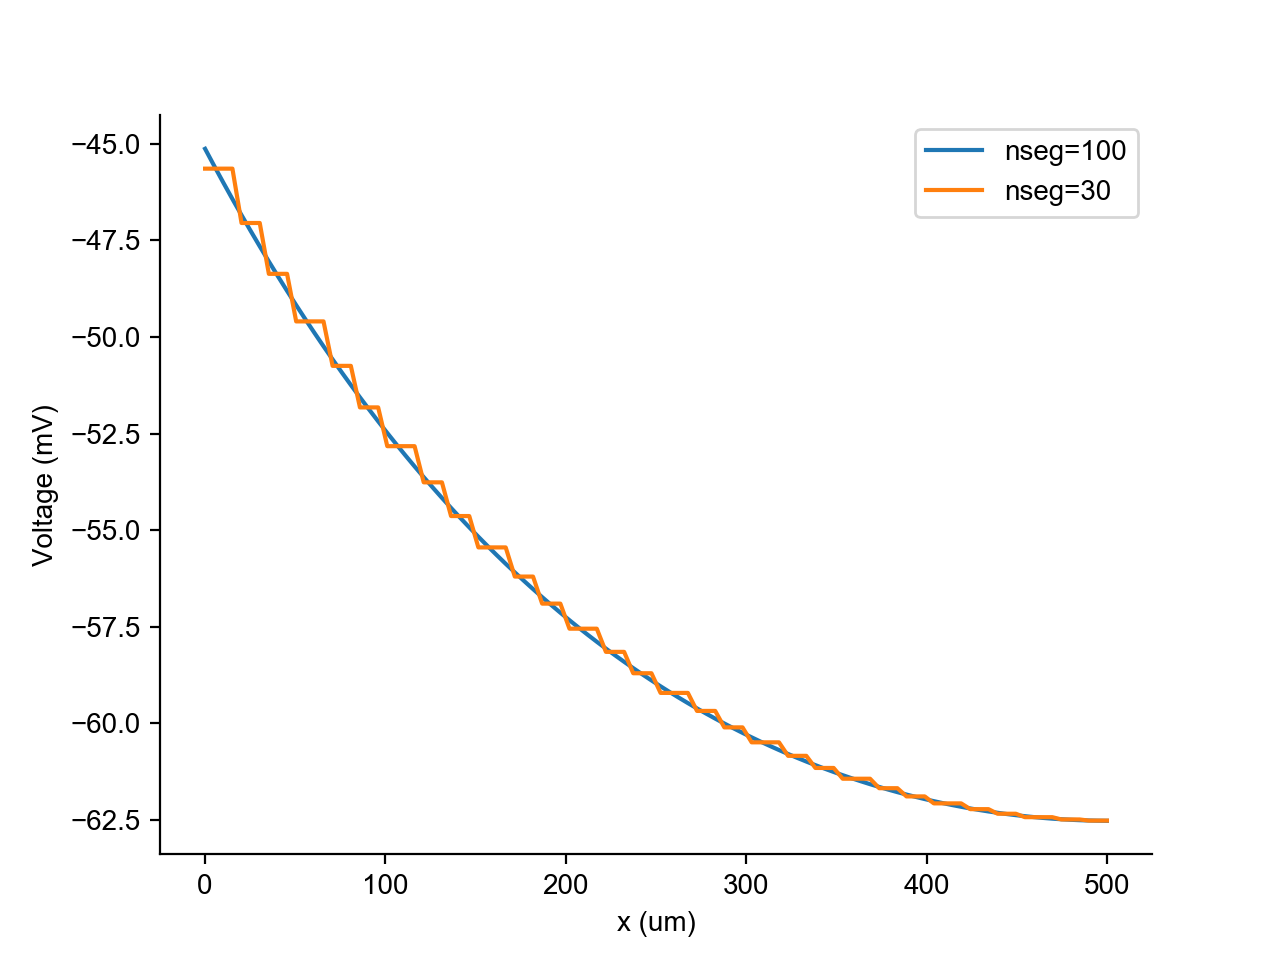

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'x (um)')]

In [8]:
recs_100 = recs # Save our previous result

axon.nseg = 30 # Change nseg
ic.loc(1e-3) # Relocate the current clamp electrode

reclist = run_and_record(100)
recs_30 = CNSutil.convert_to_array(reclist)

fig, ax = plt.subplots()
ax.plot(x, recs_100[-1,:], label="nseg=100") 
ax.plot(x, recs_30[-1,:], label="nseg=30")
ax.legend()
ax.set(xlabel='x (um)', ylabel='Voltage (mV)')

Here we can see that maximally ~0.8 mV error arises compared to the `nseg`=100 case. Would this improve a lot if we *increase* `nseg?

<IPython.core.display.Javascript object>


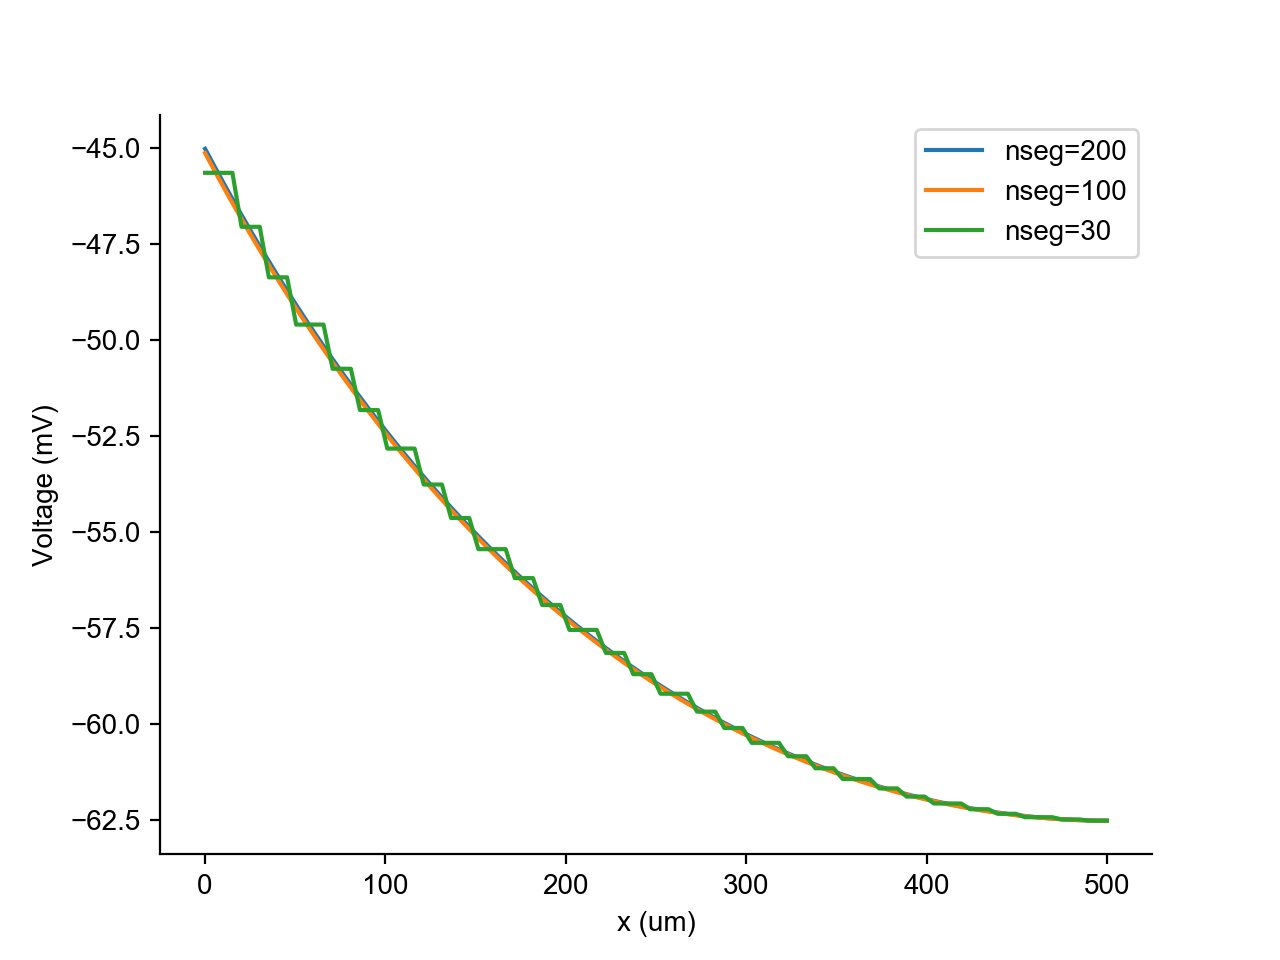

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'x (um)')]

In [9]:
axon.nseg = 200
ic.loc(1e-3) # Relocate the current clamp electrode

reclist = run_and_record(100)
recs_200 = CNSutil.convert_to_array(reclist)

fig, ax = plt.subplots()
ax.plot(x, recs_200[-1,:], label="nseg=200") 
ax.plot(x, recs_100[-1,:], label="nseg=100") 
ax.plot(x, recs_30[-1,:], label="nseg=30")
ax.legend()
ax.set(xlabel='x (um)', ylabel='Voltage (mV)')

The `nseg=200` result is almost overlapping with the `nseg=100`, and so we can see that the advantage is quite small.

### 2.2

Here we insert the Hodgekin-Huxley mechanism while turning off the previous passive membrane, and run the simulation again:

In [10]:
axon.insert('hh')
axon.g_pas = 0

<IPython.core.display.Javascript object>


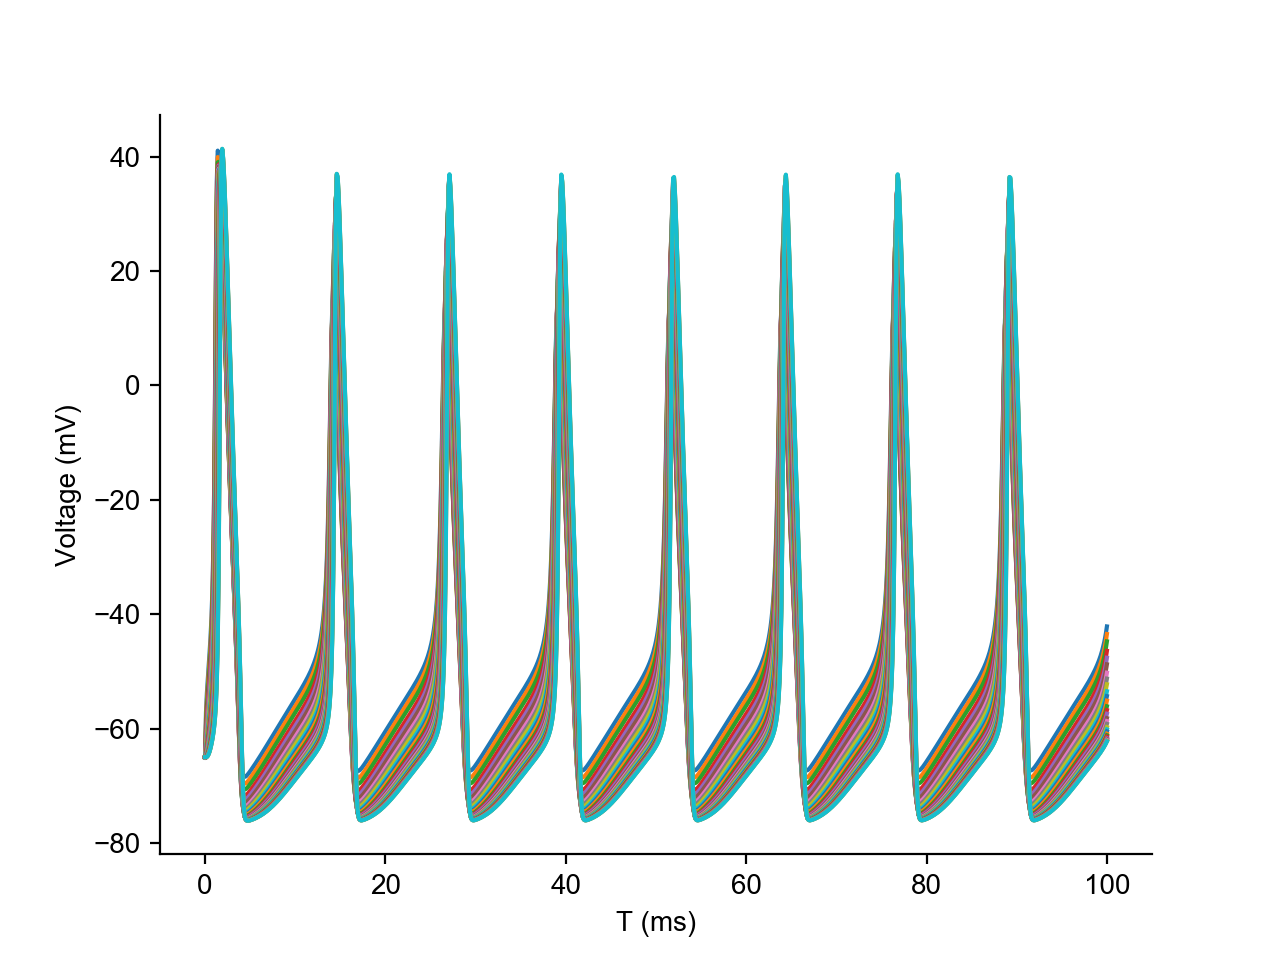

<IPython.core.display.Javascript object>


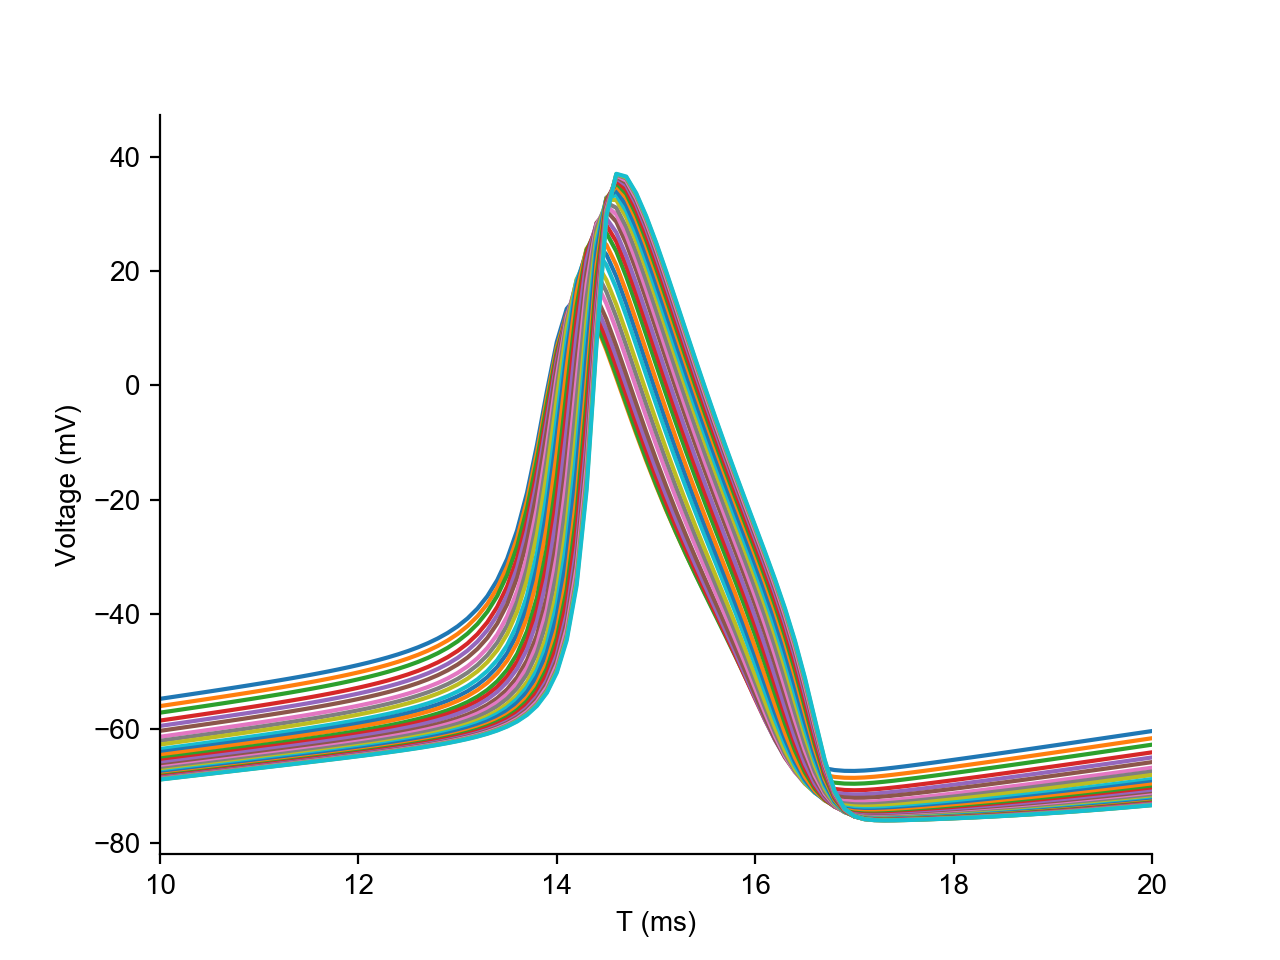

(10, 20)

In [12]:
axon.nseg = 100 
ic.loc(1e-3) # relocate the current clamp electrode

reclist = run_and_record(30)

%matplotlib notebook
_ = plot_recordings(reclist)

# Here another plot focusing on a single spike
_ = plot_recordings(reclist)
plt.xlim([10, 20])


<IPython.core.display.Javascript object>


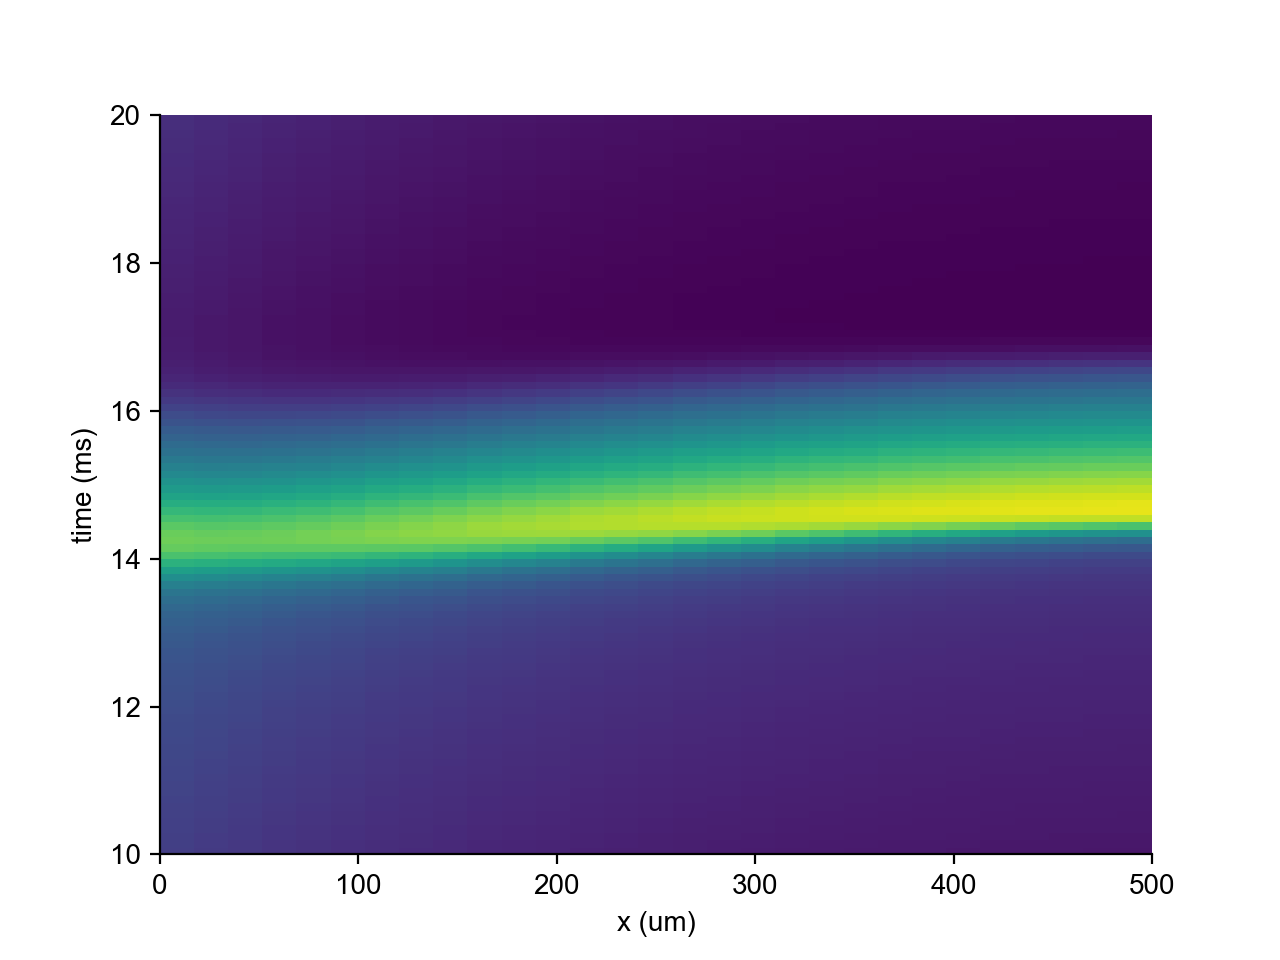

[(10, 20)]

In [13]:
recs = CNSutil.convert_to_array(reclist)

fig, ax = plt.subplots()
x = np.linspace(0, axon.L, len(reclist))
t = np.arange(1001)*dt
ax.pcolormesh(x, t, recs, shading='flat')
ax.set(xlabel='x (um)', ylabel='time (ms)')
ax.set(ylim=[10, 20])

To calculate the propagation speed, let's plot only the membrane potentials at two ends (x=0 and x=1):

<IPython.core.display.Javascript object>


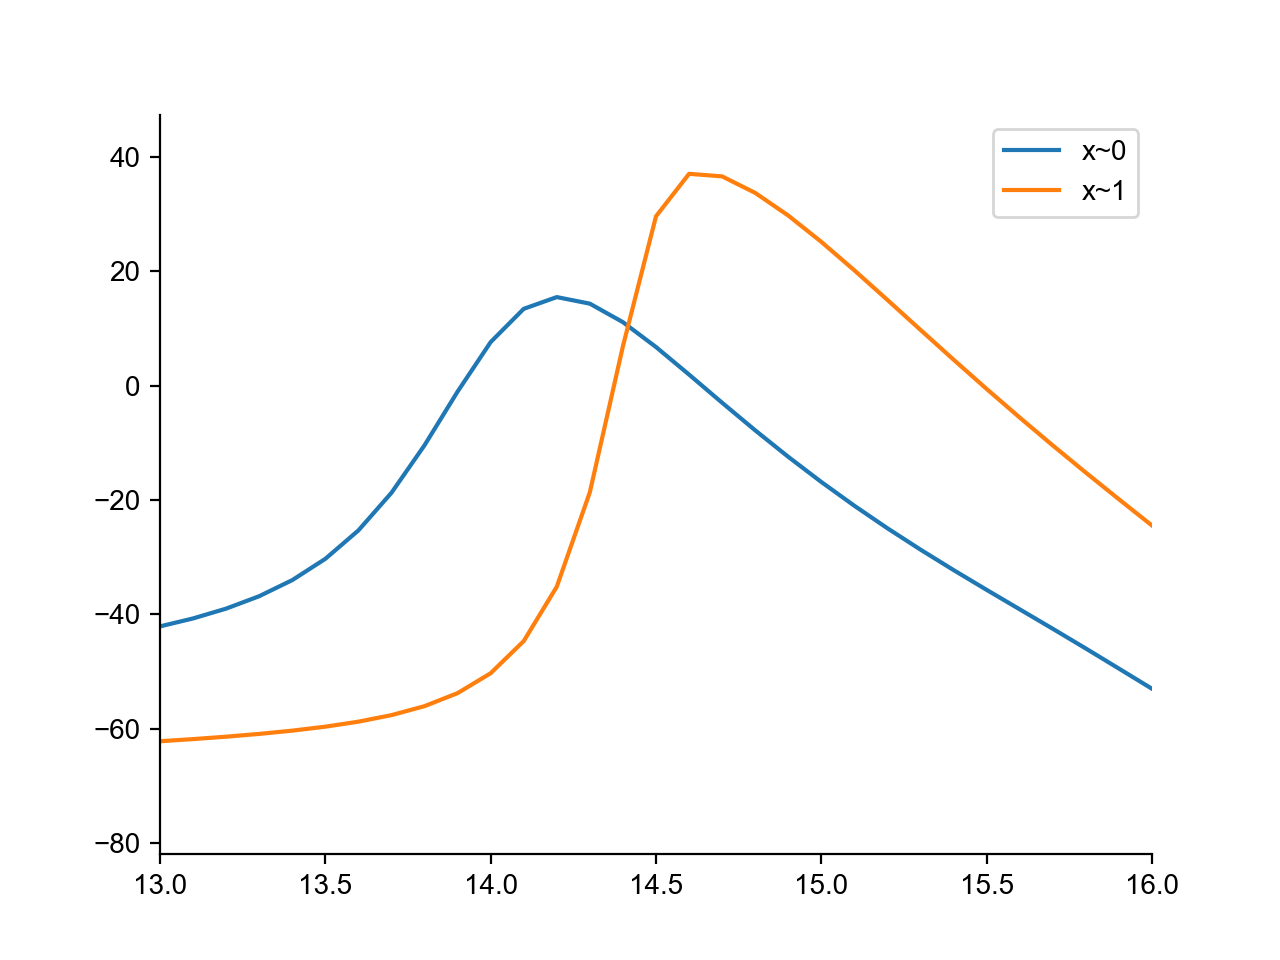

(13, 16)

In [14]:
reclist = run_and_record(100)

fig, ax = plt.subplots()
t = np.arange(1001)*dt
ax.plot(t, reclist[0], label='x~0')
ax.plot(t, reclist[-1], label='x~1')
ax.legend()
plt.xlim([13, 16])


The peaks are around *t*=14.2 ms and *t*=14.6 ms, respectively, and so the propagation speed should be around

In [17]:
print(500/(14.6-14.2)*1e-3, "m/s") # 1 um/ms = 1e-3 m/s

1.249999999999999 m/s
